In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset



tf.logging.set_verbosity(tf.logging.ERROR)
# pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

titanic_dataframe = pd.read_csv("titanic/train.csv", sep=",")

titanic_dataframe = titanic_dataframe.reindex(
    np.random.permutation(titanic_dataframe.index))

titanic_dataframe.describe()

# titanic_dataframe = titanic_dataframe[titanic_dataframe["TotRmsAbvGrd"] <= 13]
# titanic_dataframe = titanic_dataframe[titanic_dataframe["OverallQual"] <= 9.5]
# titanic_dataframe = titanic_dataframe[titanic_dataframe["GrLivArea"] <= 3500]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,891.0,714.0,891.0,891.0,891.0
mean,446.0,0.4,2.3,29.7,0.5,0.4,32.2
std,257.4,0.5,0.8,14.5,1.1,0.8,49.7
min,1.0,0.0,1.0,0.4,0.0,0.0,0.0
25%,223.5,0.0,2.0,20.1,0.0,0.0,7.9
50%,446.0,0.0,3.0,28.0,0.0,0.0,14.5
75%,668.5,1.0,3.0,38.0,1.0,0.0,31.0
max,891.0,1.0,3.0,80.0,8.0,6.0,512.3


In [2]:
def preprocess_features(titanic_dataframe, drop):#, features):
  """Prepares input features from California housing data set.

  Args:
    titanic_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """

  processed_features = pd.DataFrame()
  processed_features['Fare'] = titanic_dataframe['Fare']

  return processed_features

def preprocess_targets(titanic_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    titanic_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets["Survived"] = titanic_dataframe["Survived"]
  return output_targets
# titanic_dataframe

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(titanic_dataframe.head(691), 0)
training_targets = preprocess_targets(titanic_dataframe.head(691))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(titanic_dataframe.tail(460), 0)#, features1)
validation_targets = preprocess_targets(titanic_dataframe.tail(460))

# display.display(titanic_dataframe.describe())

# # Double-check that we've done the right thing.
# print("Training examples summary:")
# display.display(training_examples.describe())
# print("Validation examples summary:")
# display.display(validation_examples.describe())

# print("Training targets summary:")
# display.display(training_targets.describe())
# print("Validation targets summary:")
# display.display(validation_targets.describe())


In [4]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


In [5]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [6]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [7]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Survived"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Survived"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Survived"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.61
  period 01 : 0.61
  period 02 : 0.61
  period 03 : 0.61
  period 04 : 0.60
  period 05 : 0.60
  period 06 : 0.60
  period 07 : 0.59
  period 08 : 0.59
  period 09 : 0.59
Model training finished.


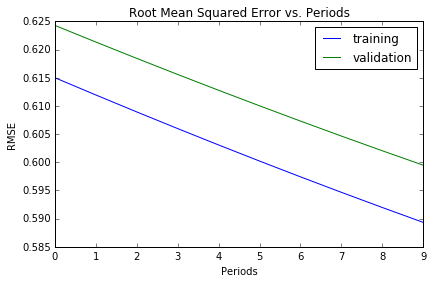

In [8]:
linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [9]:
# def train_linear_classification_model(#def train_nn_regression_model(
#     my_optimizer,
#     steps,
#     batch_size,
#     training_examples,
#     training_targets,
#     validation_examples,
#     validation_targets):

#   periods = 10
#   steps_per_period = steps / periods
  
#   # Create a DNNRegressor object.
#   my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
#   dnn_regressor = tf.estimator.LinearClassifier(
#       feature_columns = construct_feature_columns(training_examples),
# #       hidden_units=hidden_units,
#       optimizer=my_optimizer
#   )
  
#   # Create input functions.
#   training_input_fn = lambda: my_input_fn(training_examples, 
#                                           training_targets["Survived"], 
#                                           batch_size=batch_size)
#   predict_training_input_fn = lambda: my_input_fn(training_examples, 
#                                                   training_targets["Survived"], 
#                                                   num_epochs=1, 
#                                                   shuffle=False)
#   predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
#                                                     validation_targets["Survived"], 
#                                                     num_epochs=1, 
#                                                     shuffle=False)

#   # Train the model, but do so inside a loop so that we can periodically assess
#   # loss metrics.
#   print("Training model...")
#   print("RMSE (on training data):")
#   training_rmse = []
#   validation_rmse = []
#   for period in range (0, periods):
#     # Train the model, starting from the prior state.
#     dnn_regressor.train(
#         input_fn=training_input_fn,
#         steps=steps_per_period
#     )
# #     Take a break and compute predictions.
#     training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
#     training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
#     validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
#     validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
#     # Compute training and validation loss.
#     training_root_mean_squared_error = math.sqrt(
#         metrics.mean_squared_error(training_predictions, training_targets))
#     validation_root_mean_squared_error = math.sqrt(
#         metrics.mean_squared_error(validation_predictions, validation_targets))
#     # Occasionally print the current loss.
#     print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
#     # Add the loss metrics from this period to our list.
#     training_rmse.append(training_root_mean_squared_error)
#     validation_rmse.append(validation_root_mean_squared_error)
#   print("Model training finished.")

# #   # Output a graph of loss metrics over periods.
#   plt.ylabel("RMSE")
#   plt.xlabel("Periods")
#   plt.title("Root Mean Squared Error vs. Periods")
#   plt.tight_layout()
#   plt.plot(training_rmse, label="training")
#   plt.plot(validation_rmse, label="validation")
#   plt.legend()

#   print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
#   print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

#   return dnn_regressor, training_rmse, validation_rmse

In [10]:
# classifier = train_linear_classification_model(
#              my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
# #              learning_rate=0.002,
#              steps=1000,
#              batch_size=10,
#              training_examples=training_examples,#normalized_training_examples,#
#              training_targets=training_targets,#.ix[index1],
#              validation_examples=validation_examples,#normalized_validation_examples,#
#              validation_targets=validation_targets)#.ix[index2])


Training model...
RMSE (on training data):


KeyError: 'predictions'